**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1a) Load the dataset and implement the K Means algorithm. You need to find the optimal number of clusters using the
> i) elbow method

> ii) silhoette method



1b) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

1c) Experiment with different distance measures [Euclidean distance, Manhattan distance].

1d) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.


1e) Visualize the dataset to depict the clusters formed. (prefer T-SNE)

</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you need to implement Hierarchical clustering (agglomerative) on the same dataset.

2a) visualize a dendogram and find out the optimal number of clusters with the help of Dendogram. Explain the procedure.


2b) Implement Hierarchical clustering using: </br>
> i) single linkage

> ii) Complete linkage

>Visualize the clusters obtained using these linkages and compare. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
from tqdm import tqdm

$\LARGE 1a)$

In [2]:
# data set loaded.
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

# you can performs your training on train/test dataset alone if there are computational issues

*Elbow method*

In [3]:
#implement elbow method from scratch
def elbow(train_data, k_list = [3,5,7,8,9,10,11,12,13]):
    """
    Apply Kmeans with the given k's and plot the scores v/s k_list.
    """
    SSDs = []
    for i in range(len(k_list)):
        k_means = Kmeans(train_data,
                         k = k_list[i],
                         centroid_initialization = 'random', 
                         no_of_iter = 75,
                         dist_measure = 'euclidean')
        k_means.fit()
        SSDs.append(k_means.getSSD())
    return (k_list, SSDs)


*Silhouette method*

In [10]:
#implement silhouette method from scratch
def silhouette(train_data, k_vals):
    """
    Plot silhouette scores against no. of clusters.
    """
    shiloutte_coeff = []
    for i in range(len(k_vals)):
        k_means = Kmeans(train_data,k=k_vals[i],centroid_initialization='random', no_of_iter=75,dist_measure='euclidean')
        k_means.fit()

        shil_coeff = 0
        for j in tqdm(range(train_data.shape[0]), desc = "Progress"):
            # find the centroid of the cluster that the point belongs to, so we can calculate nearest cluster based on this
            cluster = k_means.centroids[k_means.labels[j]]
            cluster_distances = []
            
            # find the nearest cluster
            k = 0
            for cl in k_means.centroids:
                if (cl == cluster).all():
                    k+=1
                    continue
                cluster_distances.append((np.linalg.norm(cluster-cl, ord=2),k))
                k+=1
            
            # get the nearest cluster index
            k = min(cluster_distances, key=lambda t:t[0])[1]
            nearest_cluster = k_means.centroids[k]

            # compute the shiloutte_coeff and append it to the array
            # a = train_data[k_means.labels == k_means.labels[j]]
            # b = train_data[k_means.labels == k]

            a = np.mean(np.linalg.norm(train_data[k_means.labels == k_means.labels[j]] - cluster,ord=2,axis=1))
            b = np.mean(np.linalg.norm(train_data[k_means.labels == k] - nearest_cluster,ord=2,axis=1))
            shil_coeff += (b-a)/max(b,a)
        shil_coeff/= train_data.shape[0]
        shiloutte_coeff.append(shil_coeff)
    return shiloutte_coeff

$\LARGE 1b)$

* **Forgy** and **Random Initialization** are implemented as arguments given to the code.
* If we select `forgy`, it will allocate random data points as clusters, and `random` gives us the random initialization (assigning data points to certain labels). They are implemented in the member function **`initializeCentroids`**

In [5]:
#implement Kmeans from scratch
class Kmeans:
    """
    k: no.of clusters we want.
    no_of_iter: The no. of times we want to update our centroids. 
    Note that "tolerance" won't work when "no_of_iter" is given as input.
    tolerance: When tolearnce is given "no_of_iter" won't work.
    tol: "True" or "False" to avoid conflict between "no_of_iter" and "tolerance".
    """
    def __init__(self, data, k=3, centroid_initialization='forgy', no_of_iter=20, tol = False, tolerance=0.0001, dist_measure='euclidean'):

        # data is in the shape of NxD, where N is the number of samples and D is dimensions
        self.data = data
        self.k = k
        self.initialization = centroid_initialization
        self.no_of_iter = no_of_iter
        self.tol_bool = tol
        self.tol = tolerance
        self.dist = dist_measure
        self.centroids = []
        self.labels = []
        self.SSD = [np.inf]
        
    def calculateError(self):
        SSD = 0
        for i in range(self.k):
            data = self.data[self.labels==i]
            mean = data.mean(axis=0)
            SSD+= np.sum(np.linalg.norm(data-mean,ord=2,axis=1))
        self.SSD.append(SSD)
        
    def getSSD(self):
        return self.SSD[self.no_of_iter-1]
    
    def initializeCentroids(self):
        if self.initialization=='forgy':
            self.centroids = self.data[np.random.choice(self.data.shape[0], self.k, replace=False),:]
        else:
            # random partition.
            # randomly assign data points to k clusters and return their means
            assignment = np.random.choice(self.k, size=self.data.shape[0], replace=True)
            for i in range(self.k):
                self.centroids.append( np.mean(self.data[assignment == i,:], axis=0) )
    
    def calculateDistances(self):
        distances = np.zeros((self.k, self.data.shape[0]))
        if self.dist == 'euclidean':
            for i in range(self.k):
                distances[i] = np.linalg.norm(self.data - self.centroids[i],axis=1,ord=2)
        else:
            for i in range(self.k):
                distances[i] = np.linalg.norm(self.data - self.centroids[i],axis=1,ord=1)
        return distances
    def fit(self): 
        self.initializeCentroids()
        print("Centroids are initialized ...")
        if not self.tol_bool:
            for i in tqdm(range(self.no_of_iter), desc = "Progress"):
                distances = np.array(self.calculateDistances())
                self.labels = np.argmin(distances,axis=0)
                for k in range(self.k):
                    self.centroids[k] = self.data[self.labels==k,:].mean(axis=0)
                self.calculateError()
        else:
            err = -np.inf
            while np.abs(self.getSSD() - err) > self.tol:
                distances = np.array(self.calculateDistances())
                self.labels = np.argmin(distances,axis=0)
                for k in range(self.k):
                    self.centroids[k] = self.data[self.labels==k,:].mean(axis=0)
                err = self.getSSD()
                self.calculateError()
        print("Done!\n")

$\LARGE 1c)$

In [3]:
N = trainX.shape[0]
d = trainX.shape[1]
d = d**2
train_data = np.zeros((N,d),dtype=np.uint8)
for i in range(N):
    train_data[i] = trainX[i].ravel()
print(train_data.shape)

(60000, 784)


Taking the euclidean and manhattan distances and comparing them

In [7]:
# Euclidean.
k_means_euc = Kmeans(train_data,k=10,centroid_initialization='random', no_of_iter=75,dist_measure='euclidean')
k_means_euc.fit()
 
# manhattan
k_means_man = Kmeans(train_data,k=10,centroid_initialization='random', no_of_iter=75,dist_measure='manhattan')
k_means_man.fit()

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [03:57<00:00,  3.16s/it]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [03:56<00:00,  3.15s/it]

Done!



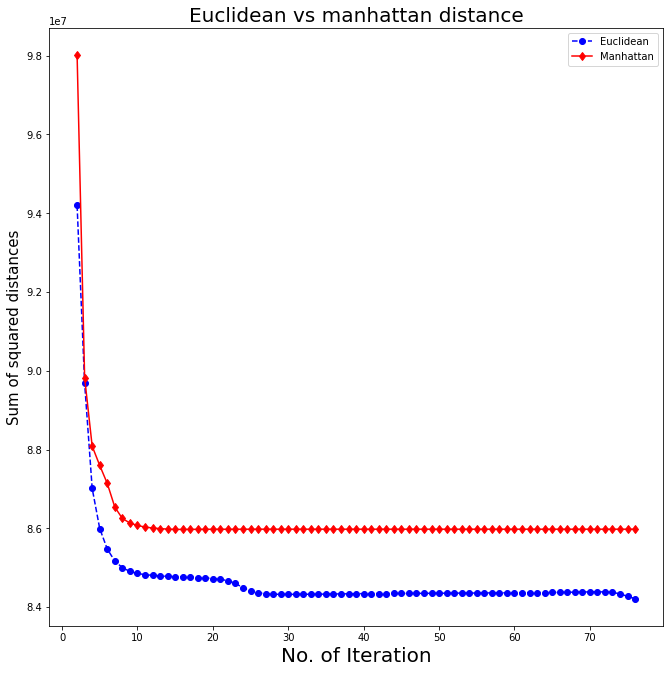

In [8]:
plt.figure(figsize=(11,11))
plt.plot([x for x in range(1,77)],k_means_euc.SSD,'--bo', label = "Euclidean")
plt.plot([x for x in range(1,77)],k_means_man.SSD,'-rd', label = "Manhattan")
plt.ylabel("Sum of squared distances",size=15)
plt.xlabel("No. of Iteration",size=20)
plt.legend(loc = "best")
plt.title("Euclidean vs manhattan distance",size=20); plt.show()

$\LARGE 1d)$

**Note: The results for both `silhouette method` and `elbow method` were for `centroid_initialization = random`, and `max iterations` of `75` with `euclidean distance metric` on first $10000$ data records.**

**For Elbow**

In [9]:
k_vals, SSDs = elbow(train_data[:10000], k_list = [2,3,4,5,6,7,8,9,10,11,12,13])

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:10<00:00,  7.42it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:12<00:00,  5.98it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:15<00:00,  4.89it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:18<00:00,  4.11it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:21<00:00,  3.57it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:23<00:00,  3.13it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:26<00:00,  2.80it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:29<00:00,  2.53it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:32<00:00,  2.31it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:35<00:00,  2.13it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


Done!

Centroids are initialized ...


Progress: 100%|██████████| 75/75 [00:40<00:00,  1.83it/s]

Done!



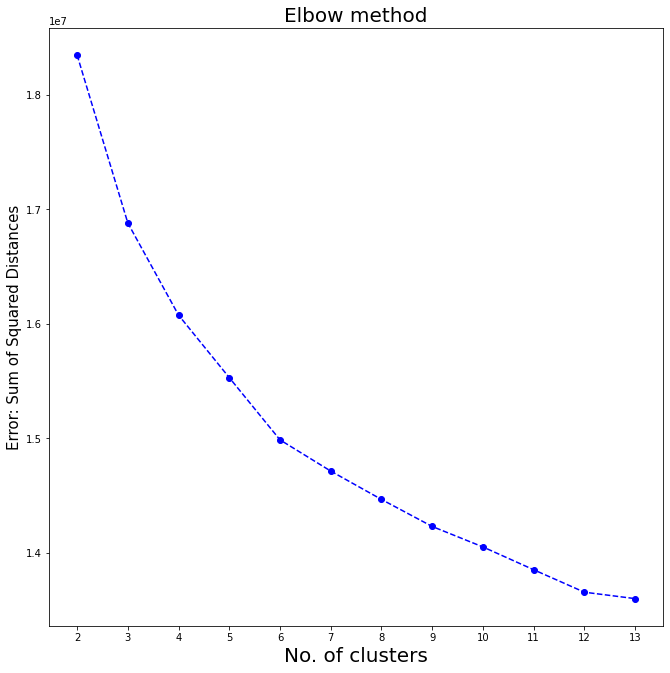

In [10]:
plt.figure(figsize=(11, 11))
plt.plot(k_vals, SSDs, '--bo')
plt.ylabel("Error: Sum of Squared Distances",size=15)
plt.xlabel("No. of clusters",size=20)
plt.xticks(k_vals, k_vals)
plt.title("Elbow method",size=20); plt.show()

**Observation:**

- As we can see, if we increae the number of clusters, the `SSD` keeps on decreasing, and we can see that after $k=6$, the error still decreases, but with somewhat flat gradient.
- The error keeps decreasing as we increase, but **The elbow points is at $k=6$**

**For Silhouette**

In [11]:
k_vals = [2,3,4,5,6,7,8,9,10,11,12,13]
shiloutte_coeff = silhouette(train_data[:10000], k_vals)#[:5000]

Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:14<00:00,  6.73it/s]


Done!



Progress: 100%|██████████| 10000/10000 [06:22<00:00, 26.15it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Done!



Progress: 100%|██████████| 10000/10000 [03:28<00:00, 47.87it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Done!



Progress: 100%|██████████| 10000/10000 [02:41<00:00, 62.02it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


Done!



Progress: 100%|██████████| 10000/10000 [02:07<00:00, 78.63it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


Done!



Progress: 100%|██████████| 10000/10000 [01:37<00:00, 102.20it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


Done!



Progress: 100%|██████████| 10000/10000 [01:31<00:00, 109.52it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Done!



Progress: 100%|██████████| 10000/10000 [01:27<00:00, 113.85it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Done!



Progress: 100%|██████████| 10000/10000 [01:13<00:00, 135.85it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Done!



Progress: 100%|██████████| 10000/10000 [00:59<00:00, 167.34it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [01:01<00:00,  1.64it/s]


Done!



Progress: 100%|██████████| 10000/10000 [00:54<00:00, 183.15it/s]


Centroids are initialized ...


Progress: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


Done!



Progress: 100%|██████████| 10000/10000 [00:52<00:00, 191.06it/s]


Centroids are initialized ...


Progress:   0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice.
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
Progress: 100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


Done!



Progress:   0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Progress: 100%|██████████| 10000/10000 [08:56<00:00, 18.66it/s]


Text(0.5, 1.0, 'Silhouette method')

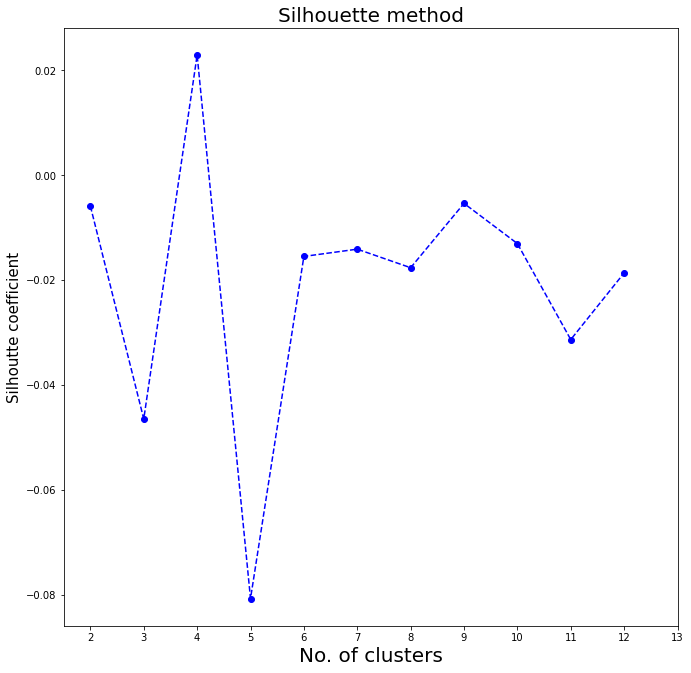

In [12]:
plt.figure(figsize=(11, 11))
plt.plot(k_vals,shiloutte_coeff,'--bo',)
plt.ylabel("Silhoutte coefficient",size=15)
plt.xlabel("No. of clusters",size=20)
plt.xticks(k_vals, k_vals)
plt.title("Silhouette method",size=20)

**Note: The results for the `silhouette method` were for first $10,000$ samples of data, `randomly initialized`, and `max iterations` of $100$ with `euclidean distance` metric**

- Since the **Silhouette** graph peaks at $k = 4$, the best cluster size is $\large 4$.
- The above considerations were taken due to computationally heavy silhouette method.

$\LARGE 1e)$

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

In [14]:
random_indices = np.random.choice(train_data.shape[0], 10000, replace=False)

sample_data = train_data[random_indices]
sample_data_labels = trainy[random_indices]

k_means_plot = Kmeans(sample_data, k=10, centroid_initialization='random',\
                      no_of_iter=100, dist_measure='euclidean')
k_means_plot.fit()

Centroids are initialized ...


Progress: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]

Done!



In [15]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, verbose=1, init='pca')#init='random'
tsne_results = tsne.fit_transform(sample_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.137s...
[t-SNE] Computed neighbors for 10000 samples in 191.624s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 406.325781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.905914
[t-SNE] KL divergence after 1000 iterations: 2.964483


<AxesSubplot:>

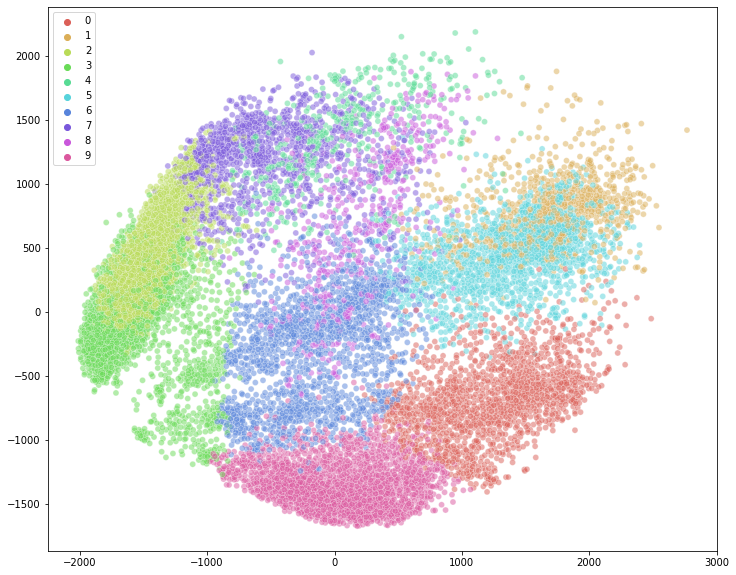

In [16]:
# Here we use k_means_plot.labels for the color labelling of the sampled points
plt.figure(figsize=(12,10))
sns.scatterplot(x = tsne_results[:,0], y = tsne_results[:,1],\
                hue = k_means_plot.labels, palette = sns.color_palette("hls",10),\
                legend="full", alpha=0.5)

# Question 2 

$\LARGE 2a)$

 - Visualize a dendogram and find out the optimal number of clusters with the help of `Dendogram`. Explain the procedure.

Hierarchical clustering

In [14]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [15]:
# implement hierarchical clustering ( you can use scikit module)

def hierarchical_clustering(data, no_of_clusters, linkage_type):
    """
    Implement Clustering Algorithm - Agglomerative clustering
    """
    clustering = AgglomerativeClustering(n_clusters = no_of_clusters, linkage=linkage_type, compute_distances = True)
    clustering.fit(data)
    return clustering

In [16]:
# Visualize a dendogram

def visualize_dendogram(model, linkage_type, dont_plot = False, cut = None, x_max = None):
    """
    Construct linkage matrix and visualize Dendogram.
    """
    non_leaf_nodes = model.children_
    counts = np.zeros(non_leaf_nodes.shape[0])

    n_samples = len(model.labels_)
    for i, children in enumerate(model.children_):
        current_count = 0
        for child_idx in children:
            if child_idx > n_samples:
                # these are the non-leaf nodes of the tree
                current_count += counts[child_idx - n_samples]
            else:
                current_count += 1
        counts[i] = current_count
    # Construct linkage Matrix
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    if dont_plot:
        return linkage_matrix
    # Plot the dendogram using Linkage Matrix
    plt.figure(figsize=(25,12))
    dendrogram(linkage_matrix,
               orientation='top',
               labels=model.labels_,
               show_leaf_counts=False,
               distance_sort='descending')
    plt.xlabel("leaf nodes", size=15)
    plt.axhline(y=cut, xmin=0, xmax=x_max, linestyle = "--", linewidth = 2, color = "r")
    plt.title("Dendogram; Linkage Type = "+linkage_type, size=20); plt.show()

In [19]:
random_indices = np.random.choice(train_data.shape[0], 500, replace=False)
sample_data = train_data[random_indices]
model = hierarchical_clustering(sample_data, 10, 'complete')

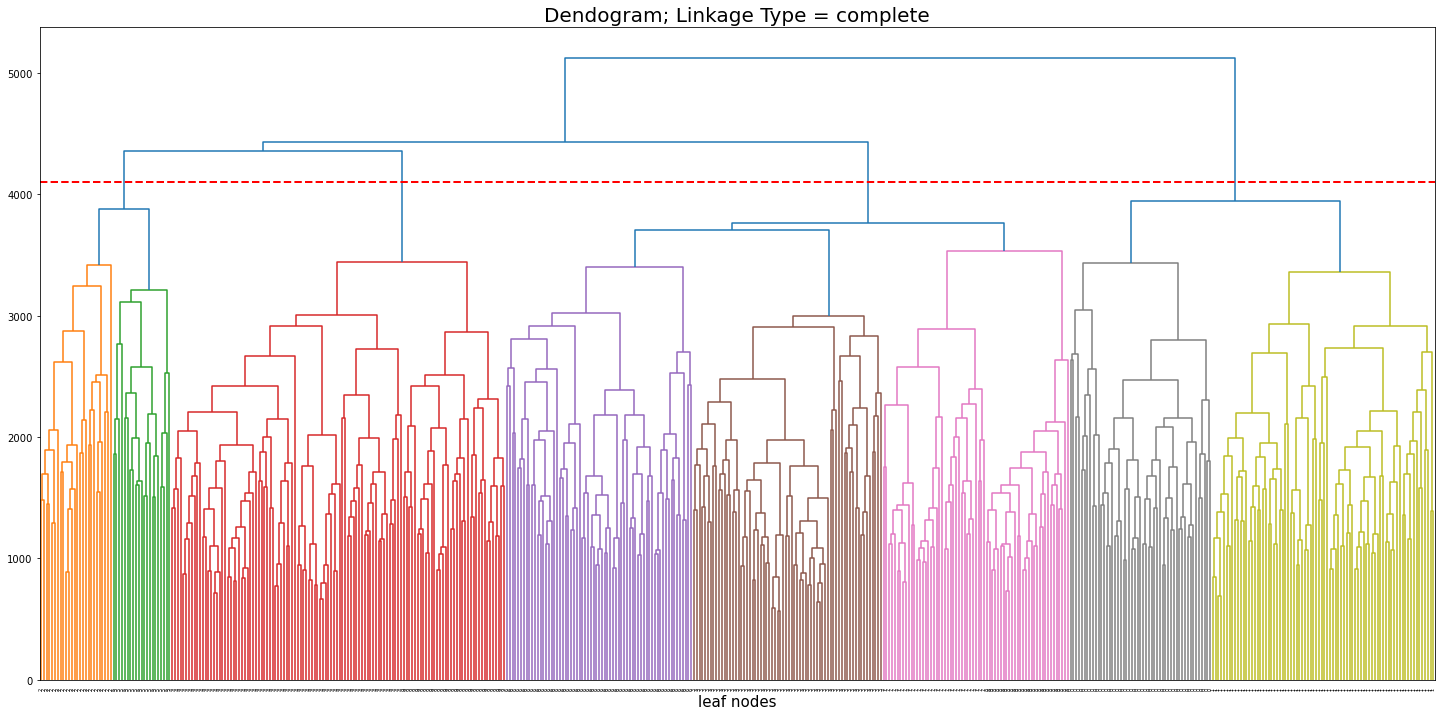

In [21]:
visualize_dendogram(model, 'complete', cut = 4100, x_max = 5000)

**Question**: Explain the procedure to find the optimal number of clusters using dendogram

Answer: 
- Based on the linkage type, we will **group the points into clusters in the lowest level** (meaning those who are nearer club them), then we do the same grouping, with clusters formed based on the type of linkage we use.
- This process happens till the all the points come under one big cluster.
- Once we have our final big cluster, the **longest vertical distance without any horizontal line passing through is selected**, and **we draw a line horizontally through it**.
- This line will intersect with multiple dendrites/vertical lines in the dendogram.
- The number of such lines this horizontal line intersects gives the **optimal number of clusters**.
- In the above case $\mathbf{y = 4100}$ is the required line that cuts through the dendogram to give $\Large \mathbf{4}$ optimal clusters.

$\LARGE 2b)$

100%|██████████| 4/4 [00:00<00:00, 10.83it/s]


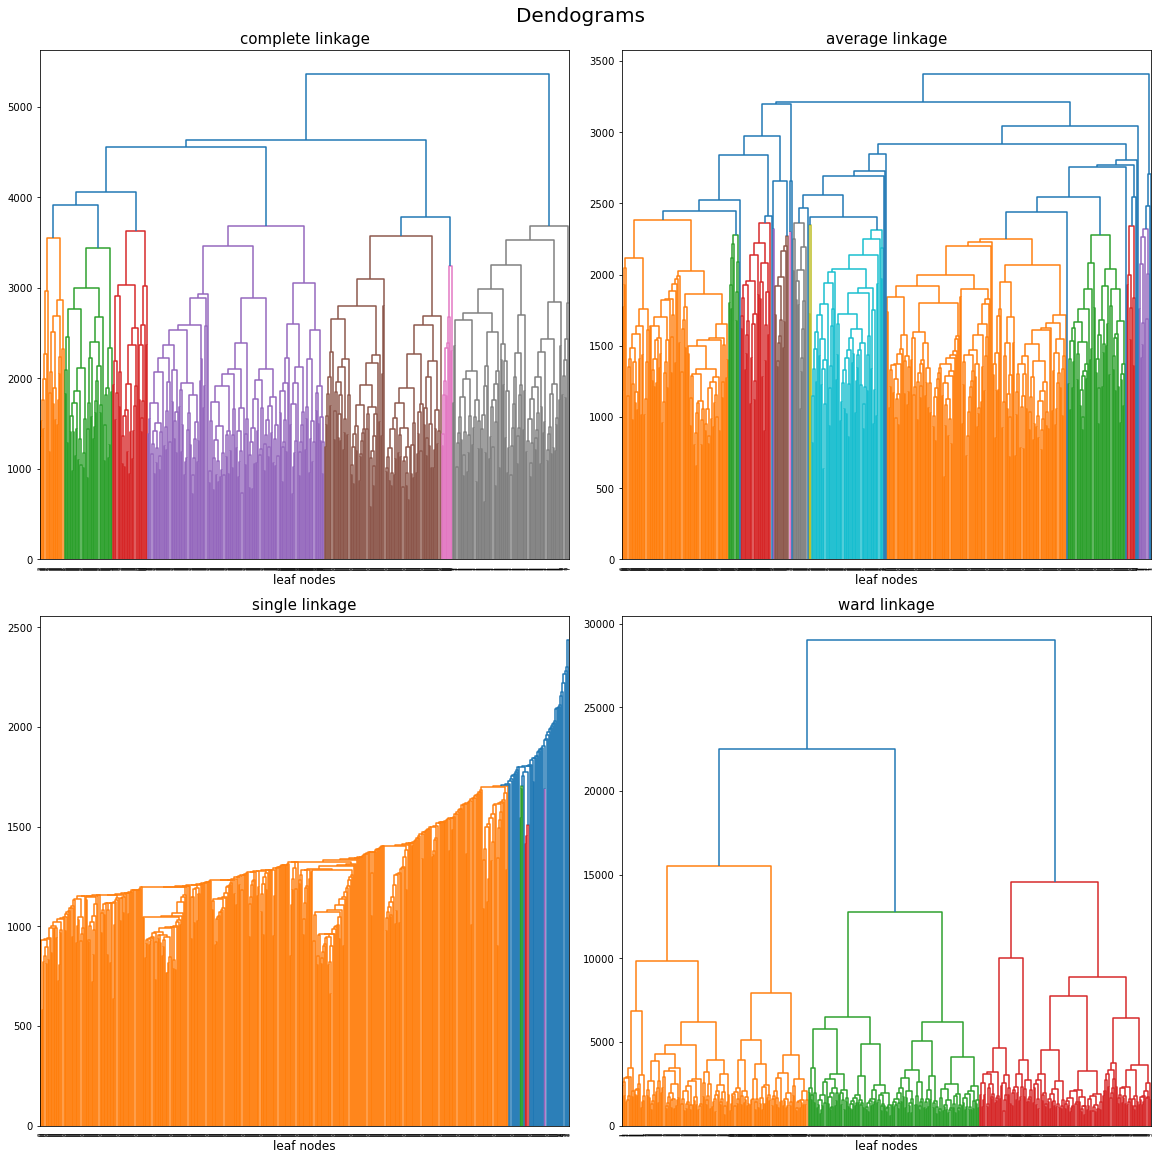

In [9]:
#visualisation of clusters using single linkage and complete linkage
linkage_matrices = []
labels = []
linkage_methods = ['complete', 'average', 'single', 'ward']
for i in tqdm(range(4)):
    model = hierarchical_clustering(sample_data, 10, linkage_type=linkage_methods[i])
    labels.append(model.labels_)
    linkage_matrices.append(visualize_dendogram(model, linkage_type=linkage_methods[i], dont_plot=True))

fig, ax = plt.subplots(2,2,figsize=(16,16), constrained_layout=True)
fig.suptitle("Dendograms", size=20)
for i in range(2):
    for j in range(2):
        dendrogram(linkage_matrices[2*i + j],
                   ax=ax[i, j],
                   orientation='top',
                   labels=labels[2*i + j],
                   show_leaf_counts=False,
                   distance_sort='descending')
        ax[i,j].set_xlabel("leaf nodes", size=12)
        ax[i,j].set_title(linkage_methods[i*2+j]+' linkage', size=15)

**Question:** Mention the differences observed using single and complete linkage:

**Answer:**

- `Single` linkage since based on **minimum** distance considers nearby point and tries to merge as much data possible in one single clusters whereas `Complete` linkage, as it considers maximum distance tries to keep clusters as far as possible due to which multiple clusters can be seen forming.
- `Single`, `complete` and `average` are the meausre of dissimilarity between two clusters and each record minimal, maximal and average inter-cluster dissimilarity respectively.
- We can observe that the *Single linkage* method, produced a dendogram that is completely **skewed to the left**. Based on the coloring of the dendrites in the graph, we can see that using **single linkage, majority of the nodes have the same label** that occurs close enough.

- Both *complete* and *average* linkage show good enough clustering. `Complete method` in this case is the one that produces best classes.

- Here `wards linkage`, instead of looking at the distances, it tries to combine the clusters which **minimize the variance**.

# Rough